In [1]:
import os
import sys
import numpy as np
import numpy.random as rnd
import pandas as pd
from scipy.special import expit

import seaborn as sns
from matplotlib import pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve

In [2]:
sys.version, sklearn.__version__, np.__version__, pd.__version__, sns.__version__

('3.7.6 (default, Jan  8 2020, 19:59:22) \n[GCC 7.3.0]',
 '0.22.1',
 '1.21.6',
 '1.0.1',
 '0.11.2')

In [3]:
seed = 0
runs = 10

In [4]:
def get_perf_df(df, value, metric, group):
    df_copy = df.copy()
    df_copy = df_copy[df_copy.Gender == group]
    close_th = (df_copy[metric]
                .sub(value)
                .abs().groupby(df_copy.Subject)
                .idxmin())
    return  df_copy.loc[close_th]

In [5]:
# DOWNLOAD AND UNZIP DATA FROM:
#    https://archive.ics.uci.edu/ml/machine-learning-databases/00427/Datasets_Healthy_Older_People.zip

dfs = []
for d in ['S1_Dataset', 'S2_Dataset']:
    for f in os.listdir(d):
        fpath = os.path.join(d, f)
        if 'README' in fpath:
            continue
        part = pd.read_csv(fpath, header=None, names=['Time',
                                                      'AccGf', 'AccGv', 'AccGl',
                                                      'IdAntenna', 'RSSI', 'Phase', 'Freq',
                                                      'Activity'])
        part['Lying'] = (part.Activity == 3).astype(int)  # lying
        part['Subject'] = f[:-1] 
        part['Gender'] = f[-1]
        dfs.append(part)
df = pd.concat(dfs)

In [6]:
df.head()

,Time,AccGf,AccGv,AccGl,IdAntenna,RSSI,Phase,Freq,Activity,Lying,Subject,Gender
0,0.000,0.31893,0.99674,0.088944,4,-57.5,1.50020,924.75,1,0,d1p37,M
1,0.025,0.31893,0.99674,0.088944,1,-56.5,5.15420,924.25,1,0,d1p37,M
2,0.250,0.31893,0.99674,0.088944,4,-58.5,5.71710,924.25,1,0,d1p37,M
3,0.500,0.31893,0.99674,0.088944,1,-57.0,5.59140,920.75,1,0,d1p37,M
4,0.550,0.31893,0.99674,0.088944,1,-57.5,0.22089,923.25,1,0,d1p37,M


In [7]:
# filter out pacients with less than 50 samples
df = df.groupby('Subject').filter(lambda x: len(x) >= 50)

In [8]:
# the subject should have at least 10 samples in each class
df = df.groupby('Subject').filter(lambda x: len(x[x.Lying == 0]) >= 6 and len(x[x.Lying == 1]) >= 6)

In [9]:
df.groupby('Subject').Gender.value_counts()

Subject  Gender
d1p01    M         401
d1p02    M         260
d1p03    M         328
d1p04    M         531
d1p05    M         498
                  ... 
d2p23    F         204
d2p24    F         615
d2p25    F         202
d2p26    F         231
d2p27    F         178
Name: Gender, Length: 74, dtype: int64

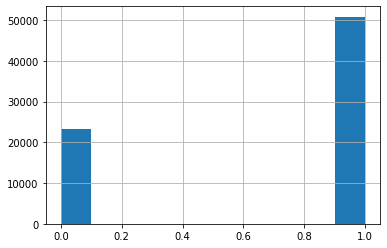

In [10]:
df.Lying.astype(int).hist()

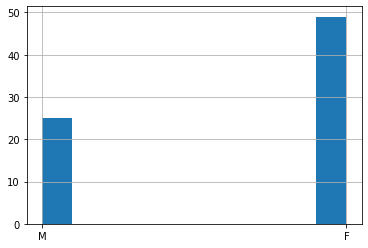

In [11]:
# dominated by females
df.groupby(['Subject', 'Gender']).count().reset_index().Gender.hist()

In [12]:
X = df.values[:, :-4]
y = df.values[:, -3].astype(int)

In [13]:
# normalize features
normalize = Normalizer()
X = normalize.fit_transform(X)

In [15]:
TPRs, FPRs, ACCs = [], [], []
m = LogisticRegression(class_weight='balanced', penalty='elasticnet', solver='saga', l1_ratio=0.99, max_iter=1000, random_state=seed)
for i in range(runs):
    X_train, X_test, y_train, y_test, _, subject = train_test_split(X, y, df[['Subject', 'Gender']],
                                                                test_size=0.3,
                                                                stratify=df.Subject,
                                                                random_state=i)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
    ACCs.append(accuracy_score(y_test, y_pred))
    TPRs.append(recall_score(y_test, y_pred))
    FPRs.append(fp / (fp + tn))
ACCs = np.array(ACCs)
TPRs = np.array(TPRs)
FPRs = np.array(FPRs)

In [16]:
ACCs.mean(), ACCs.std()

(0.843711821775063, 0.0026561923721319753)

In [17]:
TPRs.mean(), TPRs.std()

(0.820539672474782, 0.0033185886525453102)

In [18]:
FPRs.mean(), FPRs.std()

(0.1058486187600672, 0.003252979140636488)

In [20]:
results = []
for i, row in subject.drop_duplicates().iterrows():
    smask = (subject.Subject == row.Subject).astype(bool)
    y_pred = m.predict(X_test[smask, :])
    tn, fp, fn, tp = confusion_matrix(y_test[smask], y_pred, labels=[0,1]).ravel()
    fnr05 = fn / (fn + tp)
    fpr05 = fp / (fp + tn)
    scores = m.predict_proba(X_test[smask, :])
    fpr, tpr, th = roc_curve(y_test[smask], scores[:, 1], drop_intermediate=False)
    results.append((row.Subject, row.Gender, fnr05, fpr05, fpr, tpr, th))

In [21]:
results = pd.DataFrame(results, columns=['Subject', 'Gender', 'FNR05', 'FPR05', 'FPR', 'TPR', 'TH'])
results.head()

,Subject,Gender,FNR05,FPR05,FPR,TPR,TH
0,d1p48,M,0.521368,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.002136752136752137, 0.0042735042735042...","[1.6600350814123797, 0.6600350814123798, 0.649..."
1,d1p36,M,0.034783,0.028571,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.008695652173913044, 0.0173913043478260...","[1.73781740379283, 0.73781740379283, 0.7316293..."
2,d1p42,M,0.000000,0.426667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.002136752136752137, 0.0042735042735042...","[1.9297845684027521, 0.9297845684027523, 0.928..."
3,d2p02,F,0.089989,1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0011248593925759281, 0.002249718785151...","[1.9924417860992825, 0.9924417860992826, 0.992..."
4,d1p47,M,0.280543,0.012376,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0022624434389140274, 0.004524886877828...","[1.6962657887472914, 0.6962657887472915, 0.696..."


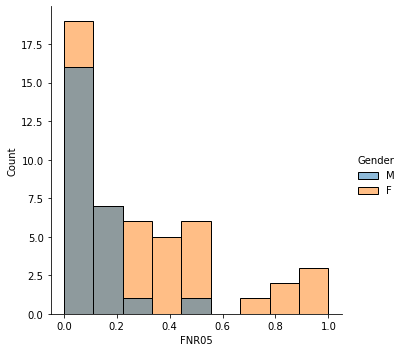

In [24]:
sns.displot(x='FNR05', hue='Gender', data=results)

In [28]:
1 - results.groupby('Gender').FNR05.mean()

Gender
F    0.717696
M    0.891005
Name: FNR05, dtype: float64

In [29]:
np.diff(1 - results.groupby('Gender').FNR05.mean())

array([0.17330867])

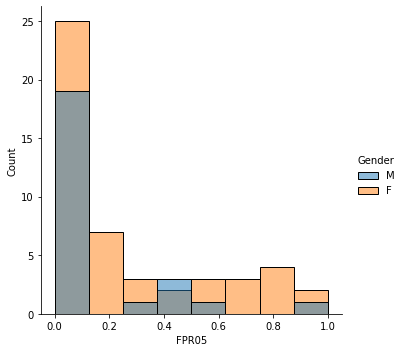

In [26]:
sns.displot(x='FPR05', hue='Gender', data=results)

In [27]:
results.groupby('Gender').FPR05.mean()

Gender
F    0.248981
M    0.152636
Name: FPR05, dtype: float64

In [30]:
np.diff(results.groupby('Gender').FPR05.mean())

array([-0.096345])